Running on schrogpu1

In [1]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
from time import time
from somoclu import Somoclu
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import sys
from collections import Counter
import seaborn as sns
from rdkit.Chem import Draw

In [2]:
suppl = Chem.SDMolSupplier("1502027397542988409.sdf")
smiles_list = []
for mol in tqdm(suppl):
    smiles_list.append([Chem.MolToSmiles(mol),mol.GetProp("_Name")])

100%|██████████| 334758/334758 [02:34<00:00, 2167.01it/s]


In [3]:
mol_df = pd.DataFrame(smiles_list,columns=["SMILES","PUBCHEM_SID"])

In [4]:
data_df = pd.read_csv("AID_488839_datatable.csv",
                      dtype={"PUBCHEM_SID": object},
                      skiprows=[1,2,3],
                      low_memory=False)

In [5]:
combo_df = mol_df.merge(data_df[["PUBCHEM_SID","PUBCHEM_ACTIVITY_OUTCOME"]],on="PUBCHEM_SID")

In [6]:
def maccs_as_np(mol):
    bv = MACCSkeys.GenMACCSKeys(mol)
    return np.array([int(x) for x in list(bv.ToBitString())],dtype=np.float32)

def morgan_as_np(mol):
    bv = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    arr = np.zeros((1,),dtype=np.float32)
    DataStructs.ConvertToNumpyArray(bv, arr)
    return arr

def generate_fps(smiles_list, fp_function=maccs_as_np):
    output_fp_list = []
    for smiles in tqdm(smiles_list, desc="Generating Fingerprints"):
        output_fp_list.append(fp_function(Chem.MolFromSmiles(smiles)))
    return output_fp_list

In [112]:
def train_somoclu_som(fp_list_in, x_dim=10, y_dim=10, use_gpu=False, num_epochs=10):
    print(len(fp_list_in))
    print("Training SOM")
    start_time = time()
    som = Somoclu(x_dim, y_dim, compactsupport=False, initialization="pca",kerneltype=int(use_gpu))
    som.train(fp_list_in,epochs=num_epochs)
    elapsed_time = time()-start_time
    print("Done\nElapsed time = %.2f sec" % elapsed_time)
    return som
    

def find_somoclu_bmu(som_in,fp_list_in):
    start_time = time()
    print("Finding BMUs")
    bmus = som_in.get_bmus(my_som.get_surface_state(fp_list_in))
    x_list = [x[0] for x in bmus]
    y_list = [x[1] for x in bmus]
    # find best matching units
    elapsed_time = time()-start_time
    print("Done\nElapsed time = %.2f sec" % elapsed_time)
    return x_list, y_list

In [113]:
fp_list = generate_fps(combo_df["SMILES"],morgan_as_np)

Generating Fingerprints: 100%|██████████| 334758/334758 [02:09<00:00, 2580.10it/s]


In [114]:
num_samples = int(len(fp_list)*0.1)
fp_list = np.array(fp_list)
train_fps = fp_list[np.random.choice(len(fp_list), num_samples, replace=False)]

In [115]:
math.sqrt(math.sqrt(num_samples)*5)

30.24580505089258

In [118]:
my_som = train_somoclu_som(train_fps,30,30,num_epochs=10,use_gpu=False)

33475
Training SOM
Done
Elapsed time = 289.79 sec


In [119]:
x,y = find_somoclu_bmu(my_som,fp_list)

Finding BMUs
Done
Elapsed time = 426.85 sec


In [18]:
combo_df["X"] = x
combo_df["Y"] = y

In [19]:
combo_df.head()

,SMILES,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,X,Y
0,CCCCCCCCNS(=O)(=O)CCNCCCC,93577678,Inactive,13,13
1,CCCCCCCCNS(=O)(=O)CCNC1CC1,93577677,Inactive,12,17
2,O=S(=O)(CCNC1CC1)NC1CCCCC1,93577676,Inactive,13,24
3,CCCCCCCCNCCS(=O)(=O)NCCCCCCCC,93577675,Inactive,13,13
4,CCCCCCCCNCCS(=O)(=O)NC1CCCCC1,93577674,Inactive,13,24


In [33]:
def depict_som(cluster_df, x_dim, y_dim, x_column="X", y_column="Y", act_column="active"):
    """
    Draw a SOM with each cell depicted as a pie chart
    :param cluster_df: data frame with SOM output, should have columns active, X, and Y
    :param x_dim: X dimension of the SOM
    :param y_dim: Y dimension of the SOM
    :return:
    """
    required_colums = [x_column, y_column, act_column]
    for col in required_colums:
        if col not in cluster_df.columns:
            print(f"Error {col} not in dataframe columns", file=sys.stderr)
            sys.exit(1)
    cell_dict = {}
    for k, v in [x for x in cluster_df.groupby([x_column, y_column])]:
        cell_dict[k] = Counter(v[act_column])
    cell_names = cluster_df[act_column].unique()
    plt.figure(figsize=(x_dim, y_dim))
    the_grid = GridSpec(x_dim, y_dim)
    for position in cell_dict.keys():
        label_fracs = [cell_dict[position][l] for l in cell_names]
        plt.subplot(the_grid[(x_dim - 1) - position[1], position[0]], aspect=1)
        patches, texts = plt.pie(label_fracs)

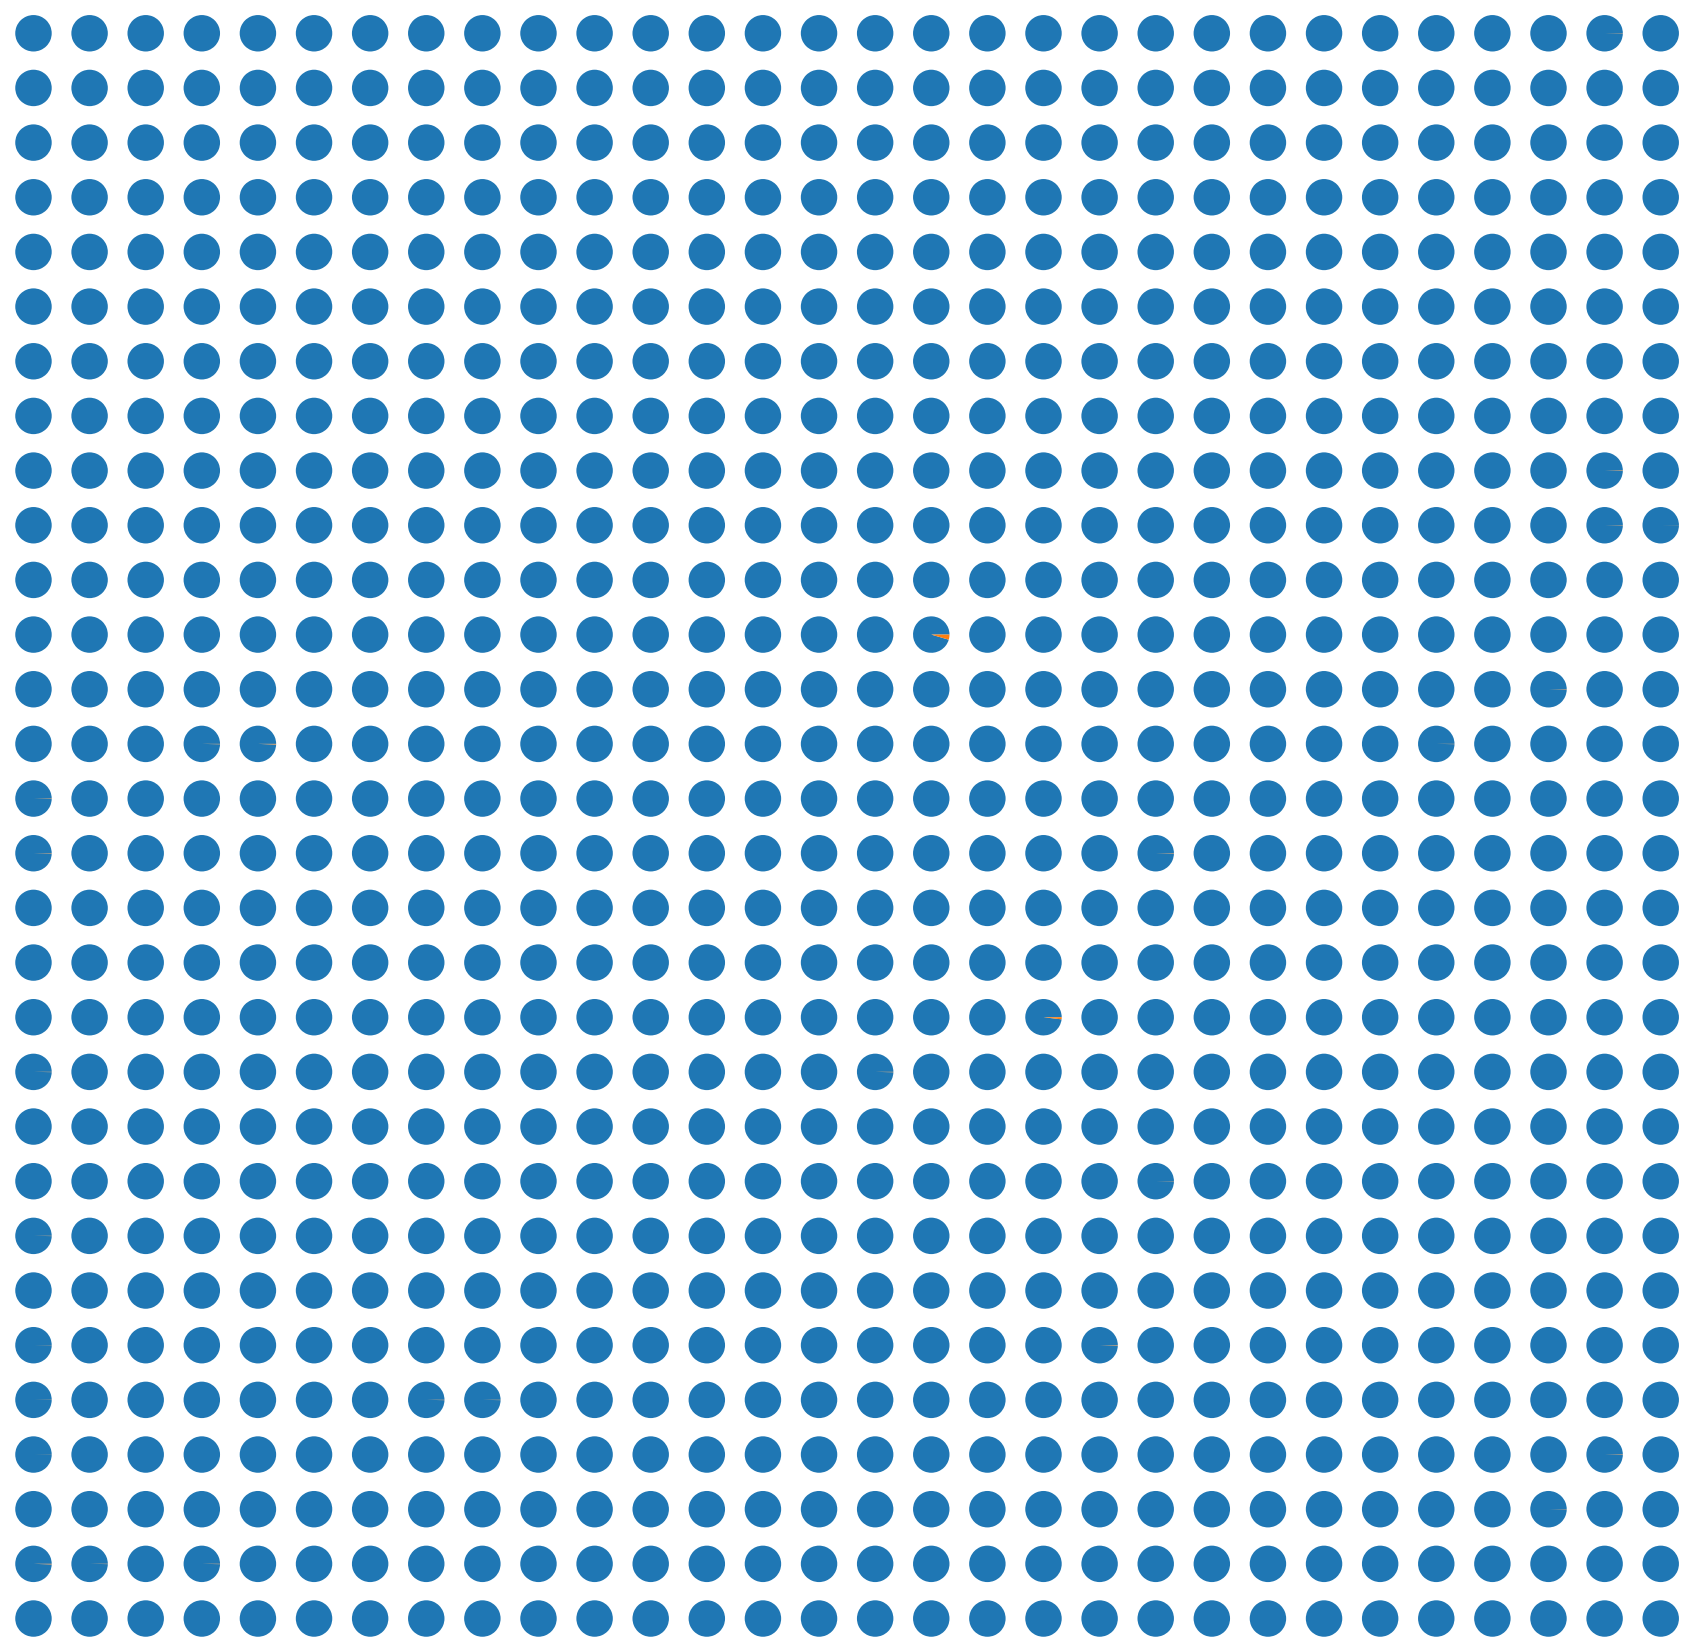

In [34]:
depict_som(combo_df,30,30,"X","Y","PUBCHEM_ACTIVITY_OUTCOME")

In [32]:
Counter(combo_df.PUBCHEM_ACTIVITY_OUTCOME)

Counter({'Inactive': 334725, 'Active': 33})

In [74]:
active_df = combo_df[combo_df.PUBCHEM_ACTIVITY_OUTCOME == "Active"].copy()
combo_gb_dict = dict([(a,b) for a,b in combo_df.groupby(["X","Y"])])
active_gb = active_df.groupby(["X","Y"])
df_list = []
for k,v in active_gb:
    x_pos,y_pos = k
    counts = Counter(combo_gb_dict[k].PUBCHEM_ACTIVITY_OUTCOME)
    num_active = counts.get("Active") or 0
    num_inactive = counts.get("Inactive") or 0
    df_list.append([x_pos,y_pos,num_active,num_inactive])
pd.DataFrame(df_list,columns=["X","Y","Active","Inactive"])

,X,Y,Active,Inactive
0,0,1,4,922
1,0,3,1,1206
2,0,4,1,838
3,0,5,1,852
4,0,7,2,1173
5,0,10,1,500
6,0,14,1,350
7,0,15,1,386
8,1,1,1,507
9,3,1,1,426


In [75]:
som_matrix = np.zeros([30,30])
for [a,b],v in active_gb:
    som_matrix[a,b] = len(v)

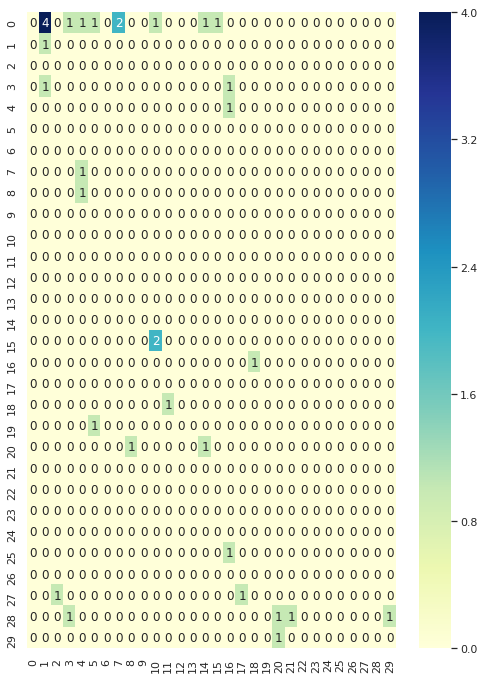

In [76]:
sns.set(rc={'figure.figsize':{11.7,8.27}})
sns.heatmap(som_matrix,annot=True,cmap="YlGnBu")

In [109]:
active_df["Pos"] = list(active_df["X"].map(str) + "," + active_df["Y"].map(str))
active_df.sort_values(["X","Y"],inplace=True)

In [110]:
active_df

,SMILES,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,X,Y,Pos
66113,CC(C)n1cnc2c(Nc3ccc(F)c(Cl)c3)nc(NCCO)nc21,49815812,Active,0,1,"0,1"
126272,CC(C)n1cnc2c(Nc3cccc(Cl)c3)nc(NCCCO)nc21,26731917,Active,0,1,"0,1"
126274,CC[C@H](CO)Nc1nc(Nc2cccc(Cl)c2)c2ncn(C(C)C)c2n1,26731915,Active,0,1,"0,1"
126395,CC(C)n1cnc2c(Nc3cccc(Cl)c3)nc(N(CCO)CCCO)nc21,26731782,Active,0,1,"0,1"
322302,Cc1ccc2nc(C(F)(F)F)c(C#N)c(N)c2c1,859461,Active,0,3,"0,3"
99645,Oc1ccc(/C=N/Nc2ccc(C(F)(F)F)cn2)c(O)c1,49670166,Active,0,4,"0,4"
133100,Nc1nc(Nc2cccc(Cl)c2)nc(NCCO)c1[N+](=O)[O-],26671622,Active,0,5,"0,5"
660,O=[N+]([O-])c1ccc2c(c1)-c1ccccc1C2=NO,93577001,Active,0,7,"0,7"
35704,O=C1NC(=O)C(c2ccccc2[N+](=O)[O-])=C1Nc1ccc(O)c(Cl)c1,56463775,Active,0,7,"0,7"
241534,O=C1Nc2ccccc2/C1=C/c1c[nH]cn1,17411478,Active,0,10,"0,10"


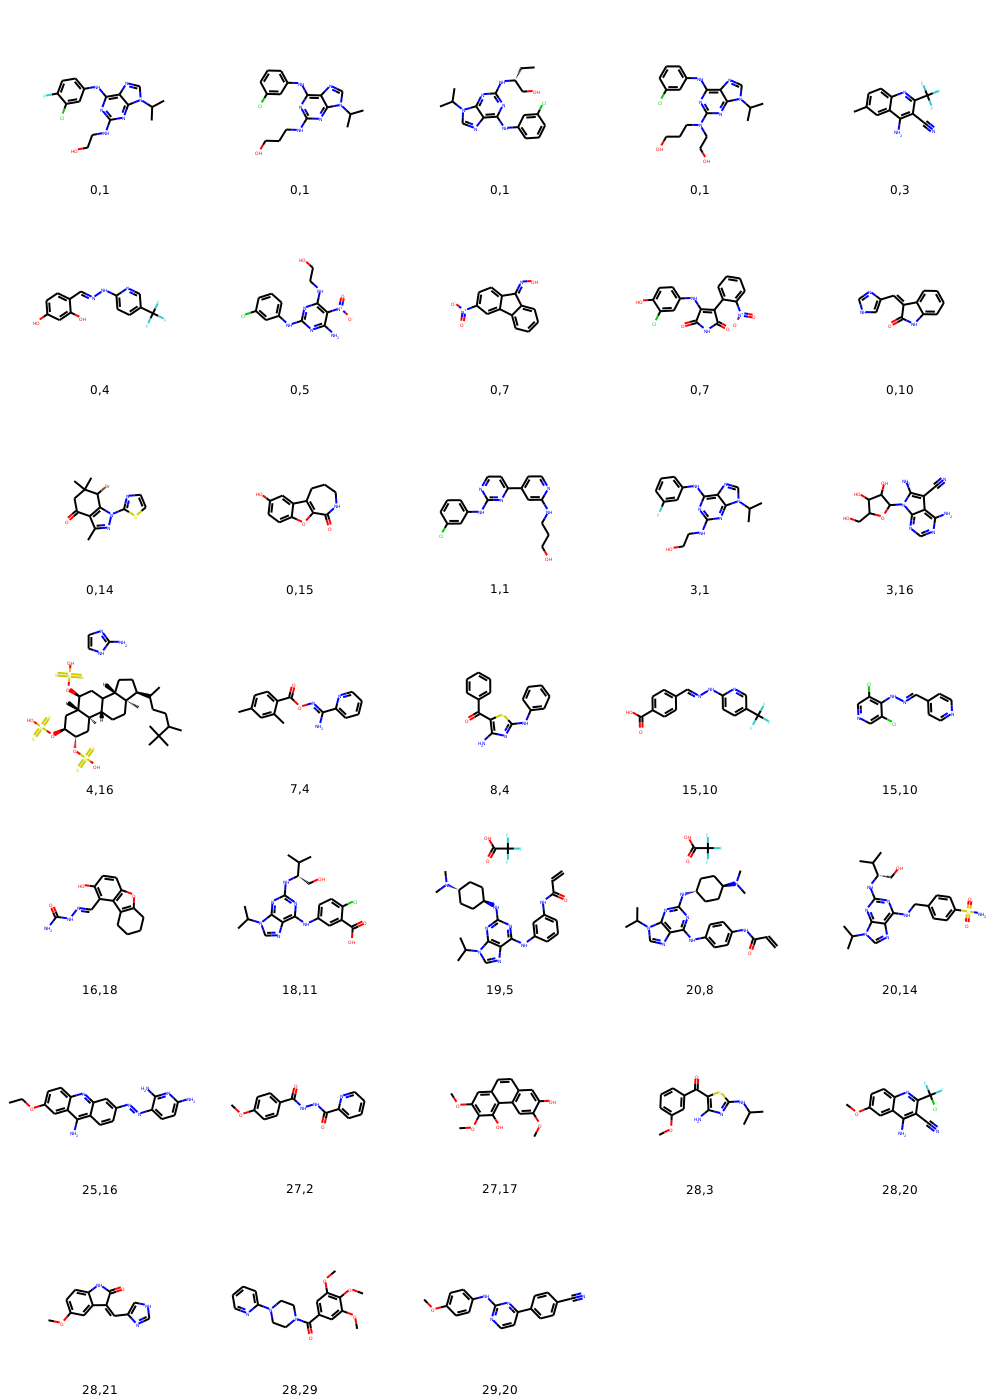

In [111]:
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in active_df.SMILES],molsPerRow=5,legends=list(active_df.Pos))